In [1]:
# Add project src to path.
import set_path
import glob

# Import modules.
import numpy as np
import time
import logging
from tqdm import tqdm

# Visulatisation
# %matplotlib widget
import matplotlib.pyplot as plt

import set_path
import src.utils.ahn_utils as ahn_utils
import src.utils.las_utils as las_utils
import src.utils.plot_utils as plot_utils
import src.utils.clip_utils as clip_utils
import src.utils.math_utils as math_utils
import src.utils.bgt_utils as bgt_utils

from src.utils.interpolation import FastGridInterpolator

from pyntcloud import PyntCloud
import pandas as pd
from skimage import feature
from scipy import ndimage
import cv2 as cv
import pyransac3d as pyrsc

import open3d as o3d
from shapely.geometry import LineString
import shapely 
from scipy.optimize import curve_fit
import scipy.spatial

from multiprocessing import Pool
from sklearn.cluster import DBSCAN

from skimage.transform import probabilistic_hough_line, hough_line, hough_line_peaks

In [2]:
def plot_cloud(points, labels, plot_3d=True):

    fig = plt.figure()
    if plot_3d:
        ax = plt.axes(projection='3d')
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(points[mask][:,0],points[mask][:,1],points[mask][:,2], s=2, label=str(label))
    else:
        ax = plt.axes()
        for label in np.unique(labels):
            mask = labels == label
            ax.scatter(points[mask][:,0],points[mask][:,1], s=1,label=str(label))
    plt.legend()
    plt.show()

In [344]:
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    print('Processing file', las_file)
    # Code
    

Processing file ../datasets/suspended_light_cables/sample1.laz
Processing file ../datasets/suspended_light_cables/sample3.laz
Processing file ../datasets/suspended_light_cables/sample2.laz
Processing file ../datasets/suspended_light_cables/sample5.laz
Processing file ../datasets/suspended_light_cables/sample4.laz


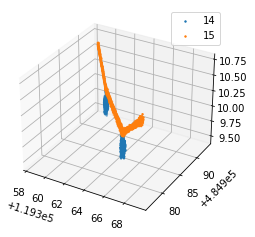

In [222]:
pointcloud = las_utils.read_las('../datasets/suspended_light_cables/sample2.laz')
true_labels = pointcloud.label
points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
labels = np.zeros(len(points))

plot_cloud(points, true_labels)

## Sampling step

In [291]:
def cable_to_linestrings(points, mask, plot=False):

    cable_dir_axis = cable_cut(points, mask)
    start_idx = cable_dir_axis[mask].argmin()
    start_pt = [points[mask][start_idx,0], points[mask][start_idx,1]]
    end_idx = cable_dir_axis[mask].argmax()
    end_pt = [points[mask][end_idx,0], points[mask][end_idx,1]]
    
    # cable height LineString (along direction)
    mean_z, _, _ = scipy.stats.binned_statistic(cable_dir_axis[mask], points[mask][:, 2], statistic='mean', bins=np.arange(0, cable_dir_axis.max(), 0.25))
    xs = np.arange(0.125, cable_dir_axis.max()-0.125, 0.25)
    ls_poitns = np.vstack((xs, mean_z)).T
    cable_height_linestring = shapely.geometry.LineString(ls_poitns)
    

    # cable planar LineString
    mean_x, _, _ = scipy.stats.binned_statistic(cable_dir_axis[mask], points[mask][:, 0], statistic='mean', bins=np.arange(0, cable_dir_axis.max(), 1))
    mean_y, _, _ = scipy.stats.binned_statistic(cable_dir_axis[mask], points[mask][:, 1], statistic='mean', bins=np.arange(0, cable_dir_axis.max(), 1))
    ls_poitns = np.vstack((mean_x, mean_y)).T
    ls_poitns = np.vstack((ls_poitns, start_pt, end_pt))
    cable_planar_linestring = shapely.geometry.LineString(ls_poitns)

    if plot:
        display(cable_height_linestring)
        display(cable_planar_linestring)

    return cable_height_linestring, cable_planar_linestring, cable_dir_axis


In [292]:
def clip_cable(points, mask, buffer=0.5):
    height_linestring, directional_linestring, cable_dir_axis = cable_to_linestrings(points, mask)

    # Height clip
    height_poly = height_linestring.buffer(buffer)
    dir_points = np.vstack((cable_dir_axis, points[:,2])).T
    height_clip_mask = clip_utils.poly_clip(dir_points, height_poly)

    # Direction clip
    directional_poly = directional_linestring.buffer(buffer)
    dir_clip_mask = clip_utils.poly_clip(points[:,:2], directional_poly)

    clip_mask = np.logical_and(height_clip_mask, dir_clip_mask)

    return clip_mask

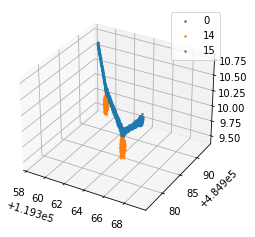

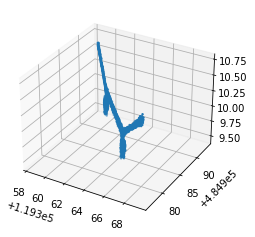

In [293]:
cable_ids = np.where(true_labels==15)[0]
cable_sample_ids = np.random.choice(cable_ids, int(len(cable_ids)*.8), replace=False)

sample_labels = true_labels.copy()
sample_labels[cable_sample_ids] = 0

plot_cloud(points, sample_labels)

cable_mask = sample_labels == 15
clip_mask = clip_cable(points, cable_mask)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(points[clip_mask][:,0],points[clip_mask][:,1],points[clip_mask][:,2], s=2)
ax.scatter(points[~clip_mask][:,0],points[~clip_mask][:,1],points[~clip_mask][:,2], s=2, c='red')

## Aproach 1

In [4]:
def main_direction(points):
    """ Returns the eigenvector corresponding to the largest eigenvalue of `points`"""
    cov = np.cov(points, rowvar=False)
    eig_val, eig_vec = np.linalg.eig(cov)
    dir_v = eig_vec[:,eig_val.argmax()]
    if dir_v[0] < 0:
        dir_v *= -1
    return dir_v

def cable_cut(points, mask):

    # Create xy-directional Axis
    cable_dir = main_direction(points[mask][:,:2])
    cable_dir_axis = np.dot(points[:,:2], cable_dir)
    cable_dir_axis -= cable_dir_axis.min()

    return cable_dir_axis

In [220]:
def projection_filter(points, true_labels):

    # Projection axis
    cable_mask = true_labels == 15
    cable_dir_axis = cable_cut(points, cable_mask)

    # Project
    grid, _, _, binnumber = scipy.stats.binned_statistic_2d(cable_dir_axis, points[:,2], np.ones(len(points)), statistic='count', bins=[np.arange(0, cable_dir_axis.max(), 0.05), np.arange(points[:,2].min(), points[:,2].max(), 0.05)], expand_binnumbers=True)
    grid_shape = np.array(grid.shape) + 1
    binindices = np.ravel_multi_index(binnumber-1, grid_shape)

    # Image filters
    grid = np.where(grid>0, True, False)
    grid = ndimage.binary_fill_holes(grid)
    grid = ndimage.binary_erosion(grid, iterations=2)
    grid = ndimage.binary_dilation(grid, iterations=2)

    fig = plt.figure()
    ax = plt.axes()
    ax.imshow(grid.T, cmap = 'gray')
    ax.invert_yaxis()

    # convert 2d back to 3d mask
    multi_index = np.array(np.where(grid>0))
    residual_bins = np.ravel_multi_index(multi_index, grid_shape)
    residual_mask = np.isin(binindices, residual_bins)

    # clustering
    clustering = (DBSCAN(eps=1, min_samples=4, p=2).fit(points[residual_mask]))

    # Plot clusters
    fig = plt.figure()
    ax = plt.axes()
    for cluster in np.unique(clustering.labels_):
        c_mask = clustering.labels_ == cluster
        cl_pts = points[residual_mask][c_mask]
        cl_centroid = cl_pts.mean(axis=0)
        ax.scatter(cable_dir_axis[residual_mask][c_mask], points[residual_mask][c_mask][:,2], s=1)
        ax.scatter(cable_dir_axis[residual_mask][c_mask].mean(), points[residual_mask][c_mask][:,2].mean(), c='k')
    #ax.scatter(cable_dir_axis[residual_mask], points[residual_mask][:,2], s=1)
    ax.scatter(cable_dir_axis[~residual_mask], points[~residual_mask][:,2], s=1)
    ax.set_ylim((points[:,2].min()-1,points[:,2].max()+1))

    return residual_mask, clustering.labels_

Processing file ../datasets/suspended_light_cables/sample1.laz


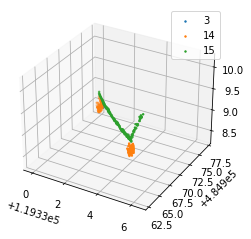

Processing file ../datasets/suspended_light_cables/sample3.laz


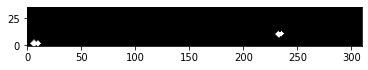

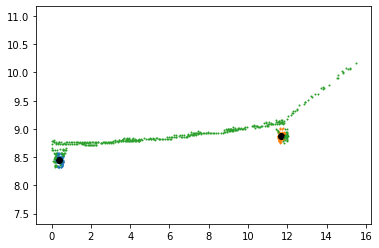

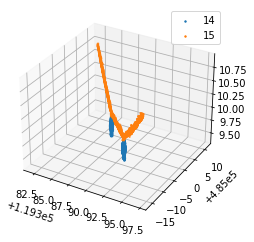

Processing file ../datasets/suspended_light_cables/sample2.laz


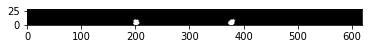

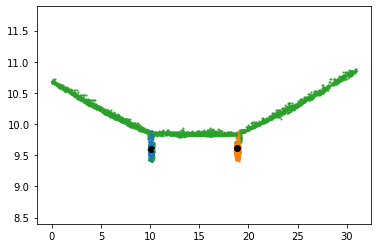

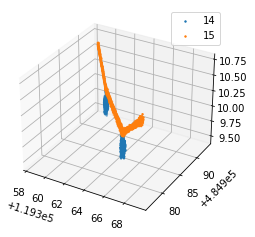

Processing file ../datasets/suspended_light_cables/sample5.laz


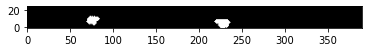

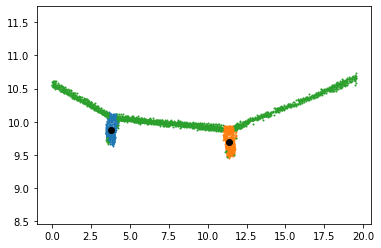

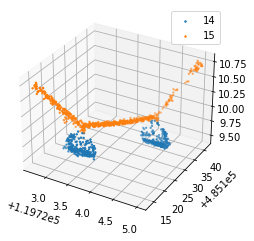

Processing file ../datasets/suspended_light_cables/sample4.laz


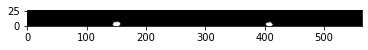

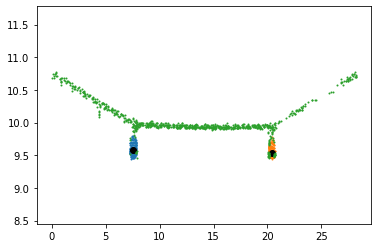

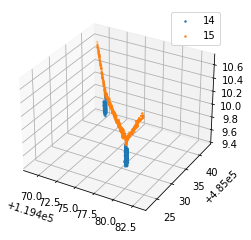

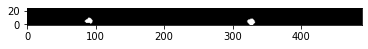

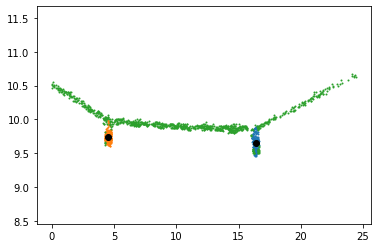

In [343]:
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    print('Processing file', las_file)
    plot_cloud(points, true_labels)
    projection_filter(points, true_labels)

## Aproach 2


In [340]:
def cable_density(points, labels, plot=True):

    # Projection axis
    cable_mask = labels == 15
    cable_dir_axis = cable_cut(points, cable_mask)

    res = scipy.stats.binned_statistic(cable_dir_axis, np.ones(len(points)), statistic='count', bins=int(cable_dir_axis.max()/0.1))
    x = (res.bin_edges[:-1]+res.bin_edges[1:])/2
    y = res.statistic / len(points)

    if plot:
        fig = plt.figure()
        ax = plt.axes()
        ax.plot(x, y)

Processing file ../datasets/suspended_light_cables/sample1.laz


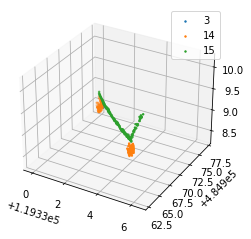

Processing file ../datasets/suspended_light_cables/sample3.laz


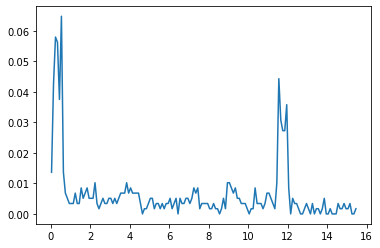

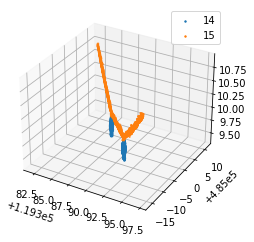

Processing file ../datasets/suspended_light_cables/sample2.laz


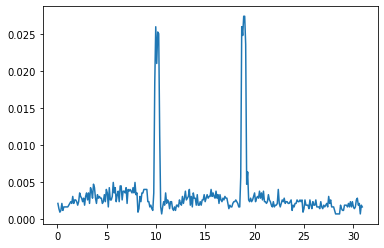

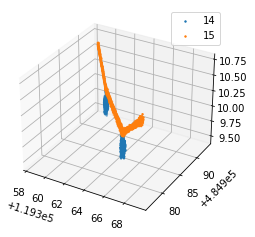

Processing file ../datasets/suspended_light_cables/sample5.laz


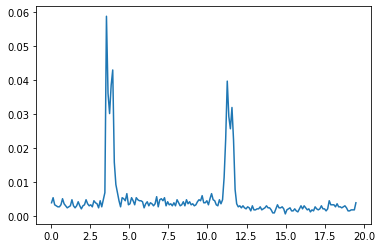

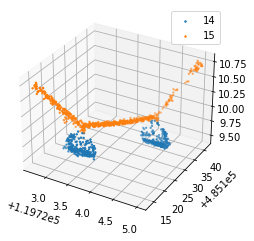

Processing file ../datasets/suspended_light_cables/sample4.laz


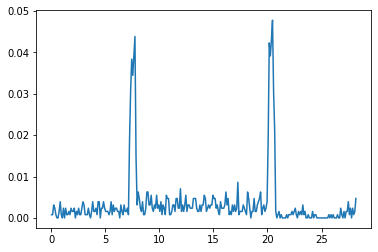

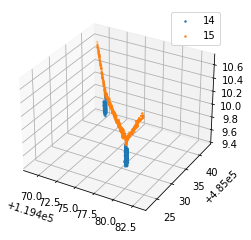

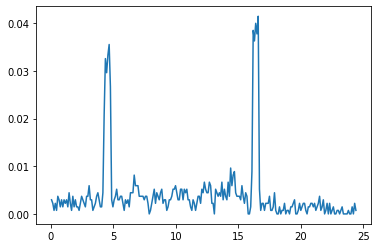

In [342]:
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    print('Processing file', las_file)
    plot_cloud(points, true_labels)
    cable_density(points, true_labels)

## Approach 3

In [307]:
def unit_vector(v1):
    """ Returns the unit vector of `v1`"""
    return v1 / np.linalg.norm(v1)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.rad2deg(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))

In [336]:
def cable_angle(points, labels, plot=True):

    cable_mask = labels == 15
    lamp_mask = labels == 14

    # Calculate directional axis
    cable_dir_axis = cable_cut(points, cable_mask)

    # cable height LineString (along direction)
    mean_z, _, _ = scipy.stats.binned_statistic(cable_dir_axis[cable_mask], points[cable_mask][:, 2], statistic='mean', bins=np.arange(0, cable_dir_axis.max(), 0.5))
    xs = np.arange(0.25, cable_dir_axis.max()-0.25, 0.5)
    ls_poitns = np.vstack((xs, mean_z)).T
    cable_height_linestring = shapely.geometry.LineString(ls_poitns)

    # Calculate angle change
    color_v = []
    for i in range(len(ls_poitns)):
        if i < 5 or i > len(ls_poitns) - 6:
            color_v.append(0.)
        else:
            v_a = ls_poitns[i] - ls_poitns[i-5]
            v_b = ls_poitns[i+5] - ls_poitns[i]
            angle = angle_between(v_a, v_b)
            color_v.append(angle)

    if plot:
        fig = plt.figure()
        ax = plt.axes()
        ax.scatter(xs, mean_z, s=4, c=color_v, cmap='Reds_r')
        ax.scatter(cable_dir_axis[lamp_mask], points[lamp_mask,2], s=2)
        ax.set_ylim((7,12))

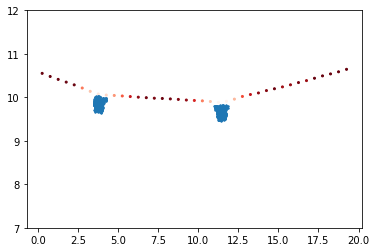

In [337]:
cable_angle(points, true_labels)

Processing file ../datasets/suspended_light_cables/sample1.laz
Processing file ../datasets/suspended_light_cables/sample3.laz
Processing file ../datasets/suspended_light_cables/sample2.laz
Processing file ../datasets/suspended_light_cables/sample5.laz
Processing file ../datasets/suspended_light_cables/sample4.laz


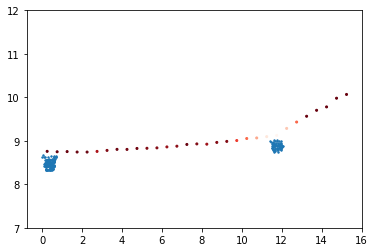

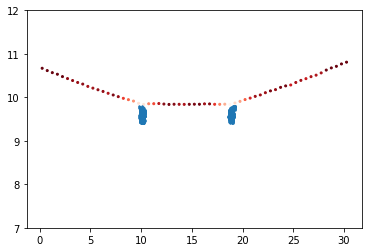

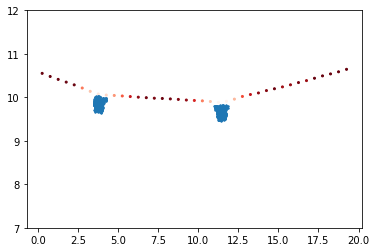

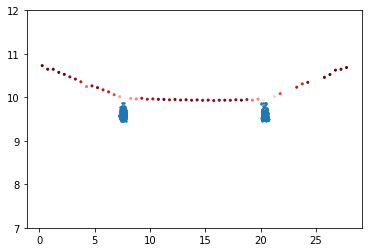

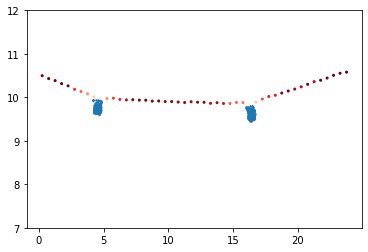

In [338]:
for las_file in glob.iglob('../datasets/suspended_light_cables/*.laz'):
    pointcloud = las_utils.read_las(las_file)
    true_labels = pointcloud.label
    points = np.vstack((pointcloud.x, pointcloud.y, pointcloud.z)).T
    labels = np.zeros(len(points))

    print('Processing file', las_file)
    cable_angle(points, true_labels)